2D Classical Ising Model NLCE Code

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import igraph
import json
from collections import defaultdict
import hashlib

Data loading and saving functions

In [149]:
def load_data(folder_path, max_order, sd_or_td):
    # load multiplicities
    try:
        multiplicities_file = f"{folder_path}/{sd_or_td}_multiplicities_o{max_order}.json"
        with open(multiplicities_file, "r") as json_file:
            multiplicities = json.load(json_file)
            multiplicities = {int(k): v for k, v in multiplicities.items()}
    except Exception as e:
        print(e)
        multiplicities = {}

    # load clusters
    try:
        clusters_file = f"{folder_path}/{sd_or_td}_clusters_o{max_order}.json"
        with open(clusters_file, "r") as json_file:
            clusters = json.load(json_file)
            clusters = {int(k): v for k, v in clusters.items()}
    except Exception as e:
        print(e)
        clusters = {}

    # load bonds
    try:
        bonds_file = f"{folder_path}/{sd_or_td}_bonds_o{max_order}.json"
        with open(bonds_file, "r") as json_file:
            bonds = json.load(json_file)
            bonds = {int(k): v for k, v in bonds.items()}
    except Exception as e:
        print(e)
        bonds = {}

    # load energies
    try:
        energies_file = f"{folder_path}/{sd_or_td}_energies_o{max_order}.json"
        with open(energies_file, "r") as json_file:
            energies = json.load(json_file)
            energies = {int(k): v for k, v in energies.items()}
    except Exception as e:
        print(e)
        energies = {}

    return multiplicities, clusters, bonds, energies

In [150]:
def save_data(multiplicities, clusters, bonds, energies, folder_path, sd_or_td):
    # check that the max order matches for all files
    if multiplicities.keys() == clusters.keys() and multiplicities.keys() == bonds.keys() and multiplicities.keys() == energies.keys():
        max_order = np.max(multiplicities.keys())
    else:
        for order in multiplicities.keys():
            if order in clusters.keys() and order in bonds.keys() and order in energies.keys():
                pass
            else:
                max_order = order -1
                break

    try:
        file_path = f"{folder_path}/energies_o{max_order}.json"
        with open(file_path, "w") as json_file:
            json.dump(energies, json_file, indent=4)
    except Exception as e:
        print(e)

NLCE functions

In [151]:
def generate_spin_configurations(order):
    # generates a list of lists, where each list is a configuration of spins
    # of length 'order', with each spin being either +1 or -1.
    # e.g. for order 3
    # [[1,1,1],
    #  [1,1,-1],
    #  [1,-1,1],
    #  [1,-1,-1],
    #  [-1,1,1],
    #  [-1,1,-1],
    #  [-1,-1,1],
    #  [-1,-1,-1]]
    num_configs = 2**order
    configurations = np.zeros((num_configs, order), dtype=int)
    for i in range(num_configs):
        for j in range(order):
            if (i // (2**j)) % 2 == 0:
                configurations[i, j] = 1
            else:
                configurations[i, j] = -1
    return configurations

In [152]:
def calculate_cluster_info(beta, J, cluster_bonds):
    # calculates the partition function and energy for a given cluster
    if not cluster_bonds: # empty list, no bonds
        return 2.0, 0.0
    

    sites = set()
    for bond in cluster_bonds:
        sites.add(bond[0])
        sites.add(bond[1])
    
    site_list = sorted(list(sites))
    site_to_index = {site: i for i, site in enumerate(site_list)}
    num_sites = len(site_list)

    configurations = generate_spin_configurations(num_sites)
    
    # Calculate partition function and energy
    Z = 0.0
    E_sum = 0.0
    for config in configurations:
        energy_coeff = 0
        for bond in cluster_bonds:
            i = site_to_index[bond[0]]
            j = site_to_index[bond[1]]
            energy_coeff += config[i] * config[j]
        
        boltzmann_factor = np.exp(J * beta * energy_coeff)
        Z += boltzmann_factor
        E_sum += energy_coeff * boltzmann_factor
    
    # Calculate average energy
    E = -J * E_sum / Z
    
    return Z, E

In [153]:
def normalize_cluster(sites):
        # normalizes the clusters so they can be compared against other clusters for symmetrical distinction
        sites = sorted(sites)
        min_site = sites[0]
        normalized = [(x - min_site[0], y - min_site[1]) for x, y in sites]
        return tuple(sorted(normalized))

def get_canonical_form(sites):
        # checks for symmetrically indistinct versions of the cluster
        canonical_forms = set()
        
        # original cluster
        canonical_forms.add(normalize_cluster(sites))
        
        # 90 degree rotation
        rotated_90 = [(-y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_90))

        # 180 degree rotation
        rotated_180 = [(-x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_180))

        # 270 degree rotation
        rotated_270 = [(y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(rotated_270))
        
        # reflection across x axis
        reflected_x = [(x, -y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_x))

        # reflection across y axis
        reflected_y = [(-x, y) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_y))

        # reflection across y=x
        reflected_diag = [(y, x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_diag))

        # reflection across y=-x
        reflected_antidiag = [(-y, -x) for x, y in sites]
        canonical_forms.add(normalize_cluster(reflected_antidiag))
        
        # return minimized cluster
        return min(canonical_forms)

def calculate_multiplicity(sites):
        # calculates the multiplicity of a specific cluster

        canonical = normalize_cluster(sites)
        
        # count how many symmetry operations leave the cluster unchanged
        identical_count = 0
        
        transformations = [
            lambda x, y: (x, y),           # identity
            lambda x, y: (-y, x),          # 90 degree rotation
            lambda x, y: (-x, -y),         # 180 degree rotation
            lambda x, y: (y, -x),          # 270 degree rotation
            lambda x, y: (x, -y),          # reflection x axis
            lambda x, y: (-x, y),          # reflection y axis
            lambda x, y: (y, x),           # reflection y=x
            lambda x, y: (-y, -x),         # reflection y=-x
        ]
        
        for transform in transformations:
            transformed = [transform(x, y) for x, y in sites]
            if normalize_cluster(transformed) == canonical:
                identical_count += 1
        
        return 8 // identical_count

In [154]:
def count_embeddings(large_cluster_coords, small_cluster_coords):
    # calculates the number of embeddings for each small cluster in a large cluster
    # e.g. checks how many times a specific order 3 cluster appears in an order 4 cluster
    
    if len(small_cluster_coords) > len(large_cluster_coords):
        return 0
    
    if len(small_cluster_coords) == len(large_cluster_coords):
        # same size - check if they're the same cluster (up to symmetry)
        return 1 if get_canonical_form(large_cluster_coords) == get_canonical_form(small_cluster_coords) else 0
    
    # get canonical form of the small cluster
    small_canonical = get_canonical_form(small_cluster_coords)
    count = 0
    
    # check all subsets of the appropriate size in the large cluster
    for subset in combinations(large_cluster_coords, len(small_cluster_coords)):
        subset_canonical = get_canonical_form(list(subset))
        if subset_canonical == small_canonical:
            count += 1
    
    return count

def calculate_weights(beta, J, orders, bonds, coordinates):
    # calculates the weights for each cluster in each order

    weights = {}
    
    # process each order sequentially
    for order in sorted(orders):
        weights[order] = []
        
        # process each cluster in this order
        for cluster_idx in range(len(bonds[order])):
            # get energy of specific cluster
            Z, E_raw = calculate_cluster_info(beta, J, bonds[order][cluster_idx])
            
            # calculate weight by subtracting embedded subclusters
            weight = E_raw
            for sub_order in range(1, order):
                if sub_order not in weights:
                    continue
                    
                for sub_cluster_idx in range(len(coordinates[sub_order])):
                    # count how many times this subcluster appears in current cluster
                    embedding_count = count_embeddings(
                        coordinates[order][cluster_idx],
                        coordinates[sub_order][sub_cluster_idx]
                    )
                    
                    if embedding_count > 0:
                        weight -= embedding_count * weights[sub_order][sub_cluster_idx]
            
            weights[order].append(weight)
    
    return weights

In [155]:
def calculate_lattice_energy(beta, J, orders, multiplicities, bonds, coordinates):
    # computes the total energy of the lattice using weights, multiplicities, and clusters

    weights = calculate_weights(beta, J, orders, bonds, coordinates)

    lattice_energy = 0.0
    for order in orders:
        for idx, multiplicity in enumerate(multiplicities[order]):
            lattice_energy += multiplicity * weights[order][idx]

    return lattice_energy

In [156]:
def get_symmetrically_distinct_clusters(order):
    # start with order 1 cluster (0,0) and build up to the desired order by adding neighboring sites to each point in the cluster
    # Once all possible clusters are generated, we will remove duplicates by checking for symmetrical equivalence
    # This way when we build clusters for the next order we only need to consider unique clusters from the previous order.

    clusters = {}
    multiplicities_dic = {1: [1]}
    
    clusters[1] = [[(0,0)]]
    
    neighboring_sites = [(1,0),(-1,0),(0,1),(0,-1)]
    
    for cluster_ord in range(2, order + 1):
        print(f"Generating clusters of order {cluster_ord}")
        clusters[cluster_ord] = []

        for prev_cluster in clusters[cluster_ord - 1]:
            prev_sites = set(prev_cluster)
            
            neighbor_candidates = set()
            for ci, cj in prev_cluster:
                for ni, nj in neighboring_sites:
                    new_site = (ci + ni, cj + nj)
                    if new_site not in prev_sites:
                        neighbor_candidates.add(new_site)
            
            for new_site in neighbor_candidates:
                new_cluster = prev_cluster + [new_site]
                clusters[cluster_ord].append(new_cluster)

        # remove duplicates
        unique_clusters = []
        unique_set = set()
        multiplicities = []
        for cluster in clusters[cluster_ord]:
            canonical = get_canonical_form(cluster)
            if canonical not in unique_set:
                unique_set.add(canonical)
                unique_clusters.append(cluster)

                multiplicity = calculate_multiplicity(cluster)
                multiplicities.append(multiplicity)
        
        multiplicities_dic[cluster_ord] = multiplicities
        clusters[cluster_ord] = unique_clusters
    
    return clusters, multiplicities_dic

def generate_bonds_from_clusters(clusters):
    # generate bonds for each cluster by connecting neighboring sites

    bonds = {}
    for order, cluster_list in clusters.items():
        bonds[order] = []
        for cluster in cluster_list:
            cluster_bonds = []
            site_set = set(cluster)
            for (x, y) in cluster:
                # Check right neighbor
                if (x + 1, y) in site_set:
                    cluster_bonds.append(((x, y), (x + 1, y)))
                # Check up neighbor
                if (x, y + 1) in site_set:
                    cluster_bonds.append(((x, y), (x, y + 1)))
            bonds[order].append(cluster_bonds)
    return bonds



Run NLCE calculation over temperatures

In [157]:
J = 1
Ti = 0.1
Tf = 10.0
num_T = 30

orders = [1,2,3,4,5,6,7,8]
sd_energies = {order: [] for order in orders}

# generate clusters and bonds up to our max order
sd_clusters, sd_multiplicities = get_symmetrically_distinct_clusters(np.max(orders))
bonds = generate_bonds_from_clusters(sd_clusters)

# iterate over temperatures so we can plot against expected result
Temps = np.linspace(Ti, Tf, num_T)

print("Calculating energies over temperature range...")

for T in tqdm(Temps):
    beta = 1 / T
    sd_weights = calculate_weights(beta, J, orders, bonds, sd_clusters)

    for order in orders:
        lattice_energy = 0.0
        for ord in range(1, order + 1):
            for idx, multiplicity in enumerate(sd_multiplicities[ord]):
                lattice_energy += multiplicity * sd_weights[ord][idx]
        sd_energies[order].append(lattice_energy)

Generating clusters of order 2
Generating clusters of order 3
Generating clusters of order 4
Generating clusters of order 5
Generating clusters of order 6
Generating clusters of order 7
Generating clusters of order 8
Calculating energies over temperature range...


100%|██████████| 30/30 [19:39<00:00, 39.32s/it]


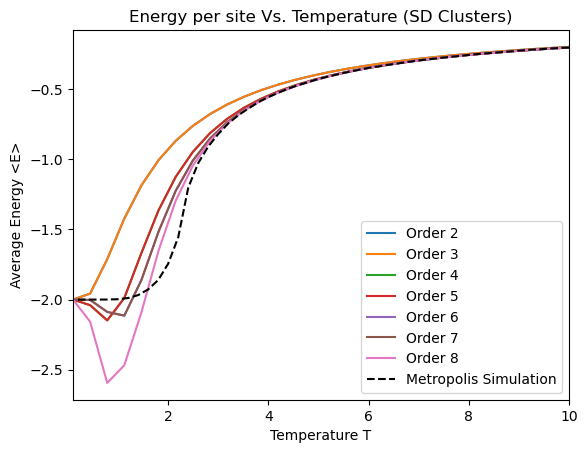

In [165]:
# plot results
for i in range(1,len(orders)):
    order = orders[i]
    plt.plot(Temps, np.array(sd_energies[order]), label=f'Order {order}')

metropolis = pd.read_csv("ising_metropolis_results.csv")
plt.plot(metropolis["T"], metropolis["Energy"], 'k--', label='Metropolis Simulation')
plt.xlabel('Temperature T')
plt.ylabel('Average Energy <E>')
plt.xlim(Ti, Tf)
plt.title("Energy per site Vs. Temperature (SD Clusters)")
plt.legend()
plt.show()

Now use topologically distinct clusters instead of symmetrically distinct

In [174]:
def cluster_to_igraph(cluster_sites):
    # creates an igraph representation of the cluster for isomorphism checking

    # Sort sites for consistent ordering
    sorted_sites = sorted(cluster_sites)
    n = len(sorted_sites)
    
    # create adjacency list
    edges = []
    for i, (x1, y1) in enumerate(sorted_sites):
        for j, (x2, y2) in enumerate(sorted_sites):
            if i < j and abs(x1 - x2) + abs(y1 - y2) == 1:
                edges.append((i, j))
    
    # Create igraph
    g = igraph.Graph(n)
    if edges:
        g.add_edges(edges)
    
    return g

def graph_hash(cluster_sites):

    # get canonical form by sorting
    sorted_sites = sorted(cluster_sites)
    n = len(sorted_sites)
    
    # get degree sequence
    degrees = [0] * n
    for i, (x1, y1) in enumerate(sorted_sites):
        for j, (x2, y2) in enumerate(sorted_sites):
            if i != j and abs(x1 - x2) + abs(y1 - y2) == 1:
                degrees[i] += 1
    
    degree_seq = tuple(sorted(degrees))
    
    # get edge count  
    edge_count = sum(degrees) // 2
    
    # create hash from invariants in the cluster
    invariants = (n, edge_count, degree_seq)
    hash_str = str(invariants)
    return hashlib.md5(hash_str.encode()).hexdigest()

def igraph_isomorphic(g1, g2):

    # check number of vertices match
    if g1.vcount() != g2.vcount():
        return False
    
    # check number of edges match
    if g1.ecount() != g2.ecount():
        return False
    
    # check isomorphism
    return g1.isomorphic(g2)

def get_topologically_distinct_clusters(clusters_dict, multiplicities_dict):
    
    td_clusters_dict = {}
    td_multiplicities_dict = {}
    
    
    for order in tqdm(clusters_dict.keys(), desc="Processing orders"):
        clusters = clusters_dict[order]
        sym_multiplicities = multiplicities_dict[order]
        
        print(f"  Order {order}: Processing {len(clusters)} clusters...")

        # first group by hash to reduce number of isomorphism checks
        hash_groups = defaultdict(list)
        for i, cluster in enumerate(clusters):
            cluster_hash = graph_hash(cluster)
            hash_groups[cluster_hash].append(i)
        
        # now process each hash group
        td_clusters = []
        td_multiplicities = []
        processed = set()
        
        for hash_key, indices in hash_groups.items():
            if len(indices) == 1:
                # unique hash - definitely distinct
                idx = indices[0]
                if idx not in processed:
                    td_clusters.append(clusters[idx])
                    td_multiplicities.append(sym_multiplicities[idx])
                    processed.add(idx)
            else:
                # If multiple clusters share the same hash, we need to do isomorphism checks
                for i, idx1 in enumerate(indices):
                    if idx1 in processed:
                        continue
                    
                    cluster1 = clusters[idx1]
                    total_mult = sym_multiplicities[idx1]
                    processed.add(idx1)
                    
                    # Convert to graph format
                    g1 = cluster_to_igraph(cluster1)

                    # Find all isomorphic clusters in this hash group
                    for idx2 in indices[i+1:]:
                        if idx2 in processed:
                            continue
                        
                        cluster2 = clusters[idx2]
                        
                        # Convert and compare
                        g2 = cluster_to_igraph(cluster2)
                        is_isomorphic = igraph_isomorphic(g1, g2)

                        
                        if is_isomorphic:
                            total_mult += sym_multiplicities[idx2]
                            processed.add(idx2)
                    
                    td_clusters.append(cluster1)
                    td_multiplicities.append(total_mult)
        
        td_clusters_dict[order] = td_clusters
        td_multiplicities_dict[order] = td_multiplicities
    
    return td_clusters_dict, td_multiplicities_dict


In [175]:
J = 1
Ti = 0.1
Tf = 10.0
num_T = 30

orders = [1,2,3,4,5,6,7,8]

td_energies = {order: [] for order in orders}

# generate symmetrically distinct clusters and multiplicities up to our max order
sd_clusters, sd_multiplicities = get_symmetrically_distinct_clusters(np.max(orders))

# use symmetrically distinct clusters to generate topologically distinct clusters and multiplicities
td_clusters, td_multiplicities = get_topologically_distinct_clusters(sd_clusters, sd_multiplicities)

# iterate over temperatures so we can plot against expected result
Temps = np.linspace(Ti, Tf, num_T)

print("Calculating energies over temperature range...")

# Generate bonds once outside the loop
td_bonds = generate_bonds_from_clusters(td_clusters)

for T in tqdm(Temps):
    beta = 1 / T
    weights = calculate_weights(beta, J, orders, td_bonds, td_clusters)

    for order in orders:
        lattice_energy = 0.0
        for ord in range(1, order + 1):
            for idx, multiplicity in enumerate(td_multiplicities[ord]):
                lattice_energy += multiplicity * weights[ord][idx]
        td_energies[order].append(lattice_energy)

Generating clusters of order 2
Generating clusters of order 3
Generating clusters of order 4
Generating clusters of order 5
Generating clusters of order 6
Generating clusters of order 7
Generating clusters of order 8


Processing orders: 100%|██████████| 8/8 [00:00<00:00, 92.68it/s]


  Order 1: Processing 1 clusters...
  Order 2: Processing 1 clusters...
  Order 3: Processing 2 clusters...
  Order 4: Processing 5 clusters...
  Order 5: Processing 12 clusters...
  Order 6: Processing 35 clusters...
  Order 7: Processing 108 clusters...
  Order 8: Processing 369 clusters...
Calculating energies over temperature range...


100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


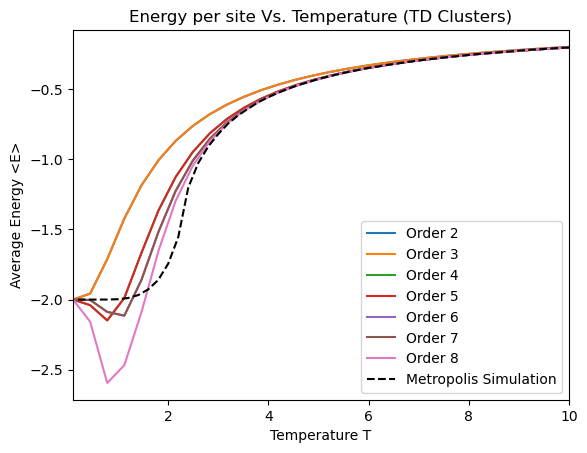

In [176]:
# plot results
for i in range(1,len(orders)):
    order = orders[i]
    plt.plot(Temps, np.array(td_energies[order]), label=f'Order {order}')

metropolis = pd.read_csv("ising_metropolis_results.csv")
plt.plot(metropolis["T"], metropolis["Energy"], 'k--', label='Metropolis Simulation')
plt.xlabel('Temperature T')
plt.ylabel('Average Energy <E>')
plt.xlim(Ti, Tf)
plt.title("Energy per site Vs. Temperature (TD Clusters)")
plt.legend()
plt.show()

In [177]:
print("Checking agreement in energy calculation between symmetrically and topologically distinct clusters...")
for order in orders:
    # print(f"Order {order}: SD: {(sd_multiplicities[order])}, TD: {(td_multiplicities[order])}")
    print(f"Order {order}: {np.array(sd_energies[order]) - np.array(td_energies[order])}")

Checking agreement in energy calculation between symmetrically and topologically distinct clusters...
Order 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Order 2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Order 3: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Order 4: [ 8.88178420e-16  0.00000000e+00  8.88178420e-16 -8.88178420e-16
  0.00000000e+00  8.88178420e-15  2.66453526e-15 -1.77635684e-15
  4.44089210e-16  4.44089210e-16  4.44089210e-16  4.44089210e-16
 -2.22044605e-16 -1.33226763e-15  1.11022302e-15  0.00000000e+00
 -4.44089210e-16  0.00000000e+00 -2.22044605e-16 -2.22044605e-16
 -7.77156117e-16 -2.22044605e-16  0.00000000e+00  6.66133815e-16
  0.00000000e+00  2.22044605e-16 -1.11022302e-16 -1.55431223e-15
  1.11022302e-16  0.00000000e+00]
Order 5: [ 6.30606678e-14  0.00000000e+00  3.55271368e-14  4.70734562e-14
  1.37667655e-14 -4.